In [1]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
from tqdm import tqdm

intrinsics = j.Intrinsics(
    height=1000,
    width=1000,
    fx=3000.0, fy=3000.0,
    cx=500.0, cy=500.0,
    near=1.0, far=10000.0
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

viz = j.o3d_viz.O3DVis(intrinsics)

model_dir = os.path.join(j.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
mesh_paths = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh_paths.append(mesh_path)
    meshes.append(j.mesh.load_mesh(mesh_path))


[Open3D INFO] EGL headless mode enabled.


In [3]:
box_dims = jnp.array([
    j.utils.aabb(m.vertices)[0] for m in meshes
])

In [4]:
table_params = (1000.0,
    800.0,
    200.0,
    10.0,
    10.0)
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
table_pose = j.t3d.inverse_pose(
    j.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 400.0, 400.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

In [5]:
table_pose

Array([[-1.0000001e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00,  7.0710671e-01, -7.0710665e-01, -2.3177286e-05],
       [-0.0000000e+00, -7.0710671e-01, -7.0710671e-01,  5.6568536e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

In [6]:
key = jax.random.PRNGKey(13)
pose_from_contact_and_face_params_multiobject_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0, 0, 0, None)))


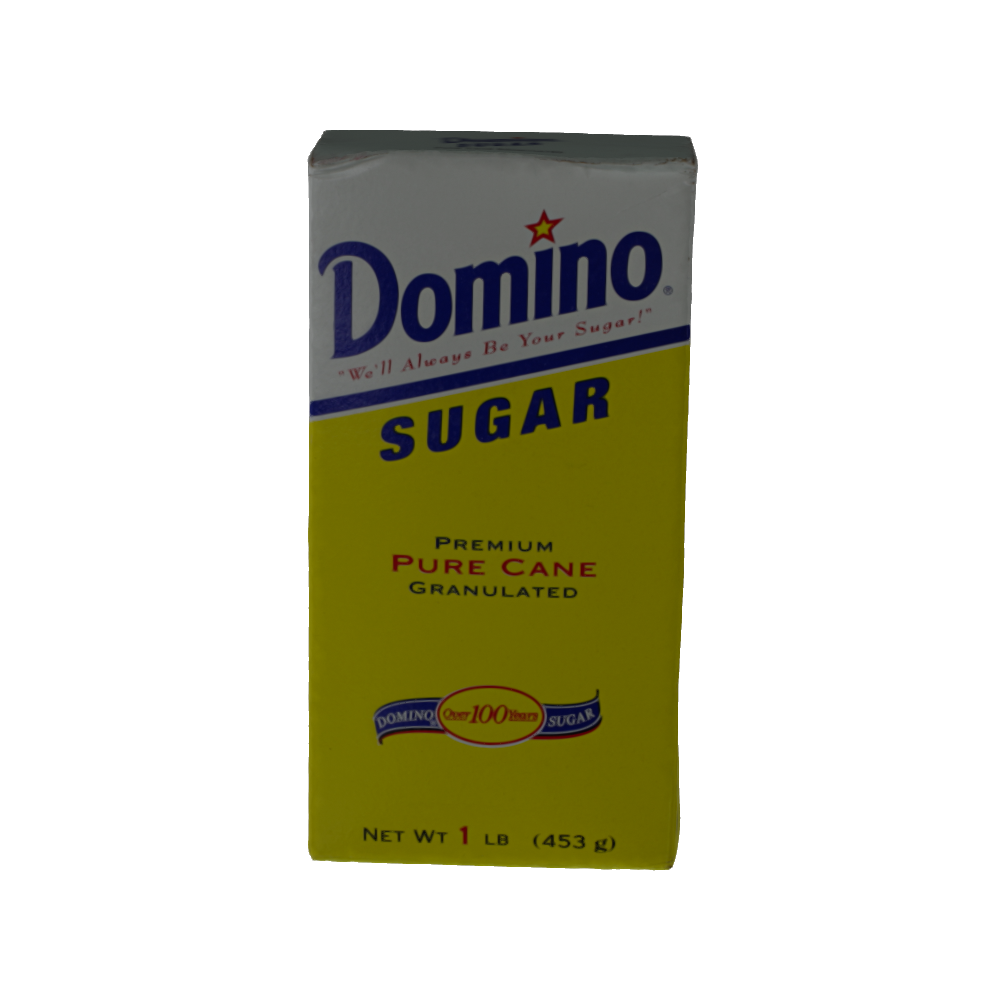

In [7]:
known_objects_ids = jnp.array([0,1,2])
camera_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([700.0, 000.0, 200.0]),
    jnp.zeros(3),
    jnp.array([0.0, 0.0, 1.0]),
)
viz.clear()
i = 2
viz.render.scene.set_lighting(viz.render.scene.LightingProfile.NO_SHADOWS, (0, 0, 0))
viz.make_mesh_from_file(mesh_paths[known_objects_ids[i]], j.t3d.inverse_pose(camera_pose))
rgbd = viz.capture_image(intrinsics, jnp.eye(4))
rgb = rgbd.rgb
rgb = rgb.at[rgbd.depth > intrinsics.far, :].set(0.0)
j.get_rgb_image(rgb)

In [8]:
table_params = (1000.0,
    1000.0,
    400.0,
    10.0,
    10.0)
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
table_pose = j.t3d.inverse_pose(
    j.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 3000.0, 1000.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

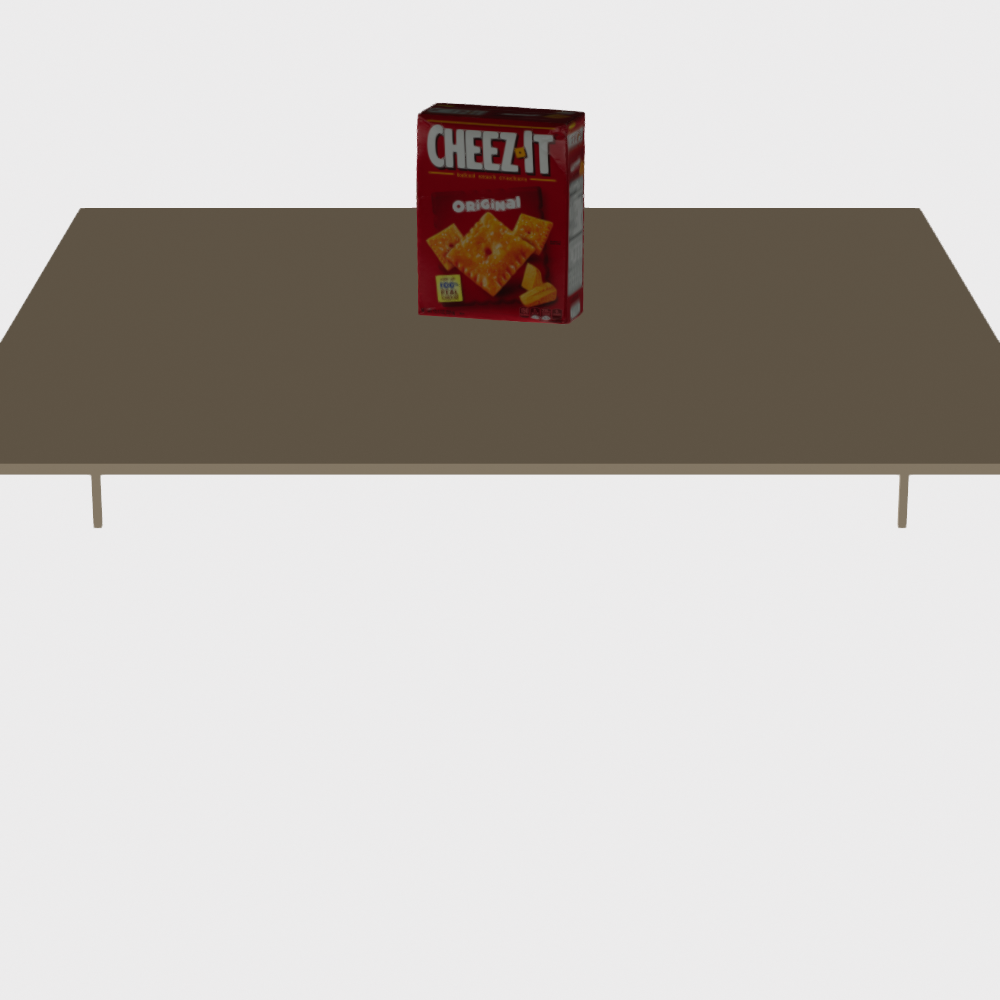

In [9]:
indices = jnp.array([1])
contact_params = jnp.array(
[
    [0.0, 0.2, 0.3]
]
)
faces = jnp.array([3])
dims_child = box_dims[indices]
poses = pose_from_contact_and_face_params_multiobject_jit(contact_params, faces, dims_child, contact_plane)

viz.clear()

viz.render.scene.set_lighting(viz.render.scene.LightingProfile.NO_SHADOWS, (0, 0, 100))

viz.make_trimesh(table_mesh, table_pose, np.array([221, 174, 126, 255.0])/255.0)

for i in range(len(indices)):
    viz.make_mesh_from_file(mesh_paths[indices[i]], poses[i])

rgbd = viz.capture_image(intrinsics, jnp.eye(4))
j.get_rgb_image(rgbd.rgb)

In [10]:
!mkdir /home/ubuntu/nishad/jax3dp3/assets/datasets

mkdir: cannot create directory ‘/home/ubuntu/nishad/jax3dp3/assets/datasets’: No such file or directory


In [11]:
for iter in tqdm(range(5)):
    key = jax.random.split(key)[1]
    indices = jax.random.choice(key,21,shape=(3,))
    contact_params = jax.random.uniform(
        key,
        shape=(3,3,),
        minval=jnp.array([-200.0,-200.0, 0.0]),
        maxval=jnp.array([200.0, 200.0, 2*jnp.pi])
    )
    faces = jnp.array([3,3,3])
    dims_child = box_dims[indices]
    poses = pose_from_contact_and_face_params_multiobject_jit(contact_params, faces, dims_child, contact_plane)

    viz.clear()

    viz.render.scene.set_lighting(viz.render.scene.LightingProfile.NO_SHADOWS, (0, 0, 100))

    viz.make_trimesh(table_mesh, table_pose, np.array([221, 174, 126, 255.0])/255.0)

    for i in range(len(indices)):
        viz.make_mesh_from_file(mesh_paths[indices[i]], poses[i])

    rgbd = viz.capture_image(intrinsics, jnp.eye(4))

    DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
    DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")
    np.savez(
        DATASET_FILE,
        intrinsics=intrinsics,
        rgb=rgbd.rgb,
        indices=indices,
        table_params=table_params,
        table_pose=table_pose,
        poses=poses,
        faces=faces
    )
    j.get_rgb_image(rgbd.rgb)

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.78s/it]


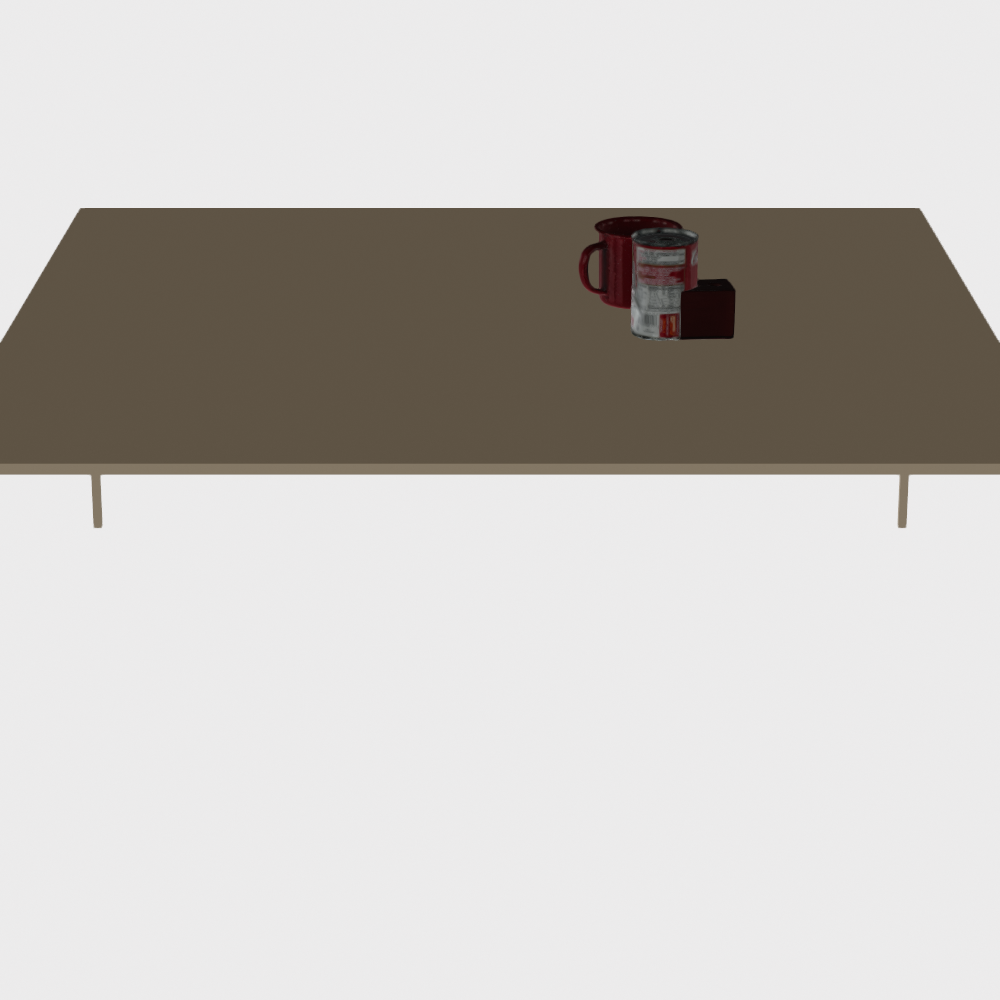

In [12]:
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")        
rgb = np.load(DATASET_FILE,allow_pickle=True)["rgb"]
j.get_rgb_image(rgb)

In [43]:
contact_params

Array([[ 9.9690521e+01,  1.8377838e+00,  2.7070867e-02],
       [ 3.5548874e+01, -5.3137543e+01,  2.9160354e+00],
       [ 9.9742493e+01,  1.6454004e+02,  4.5856538e+00]], dtype=float32)

In [44]:
indices

Array([1, 3, 2], dtype=int32)

In [52]:
renderer.model_box_dims.shape

(22, 3)

In [ ]:
observed_img = renderer.render_multiobject(
    jnp.concatenate([poses, table_pose[None,...]]),
    jnp.concatenate([indices, jnp.array([21])])
)
j.get_depth_image(observed_img[:,:,2])

2023-04-24 15:54:30.689830: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1162] failed to enqueue async memcpy from device to host: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; host dst: 0x7f929ffb98c0; GPU src: 0x7f92dec76000; size: 40000=0x9c40
2023-04-24 15:54:30.689898: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:617] unable to add host callback: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2023-04-24 15:54:30.689915: E external/xla/xla/stream_executor/stream.cc:336] Error recording event in stream: Error recording CUDA event: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; not marking stream as bad, as the Event object may be at fault. Monitor for further errors.
2023-04-24 15:54:30.689928: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:617] unable to add host callback: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered


In [ ]:
SCALING_FACTOR = 3
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
    ],
    middle_width=30
)

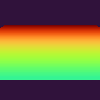

In [38]:
R_SWEEP = jnp.array([1.0, 0.5, 0.1, 0.05, 0.01]).reshape(-1,1)
R = jnp.ones((R_SWEEP.shape[0],2)) * 1.0
OUTLIER_PROBS = jnp.linspace(0.001, 0.4, 10)
OUTLIER_VOLUME = 1000.0**3

object_poses, object_ids = table_pose[None, None,...], [21]
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

contact_param_grid = j.make_translation_grid_enumeration_3d(
    -200.0, -200.0, 0.0,
    200.0, 200.0, 0.0,
    5,5,1
)
pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))

j.get_depth_image(reconstruction[:,:,2])

Object Id :  5
[  0. 200.   0.]
-100660.945
[1.   1.   0.01 0.05 1.   0.01] 0.001
Object Id :  6
[-100.  100.    0.]
-103797.74
[1.   1.   0.01 0.05 1.   1.  ] 0.045333333
Object Id :  9
[-200. -100.    0.]
-103797.74
[1.   1.   0.01 0.05 1.   1.  ] 0.045333333


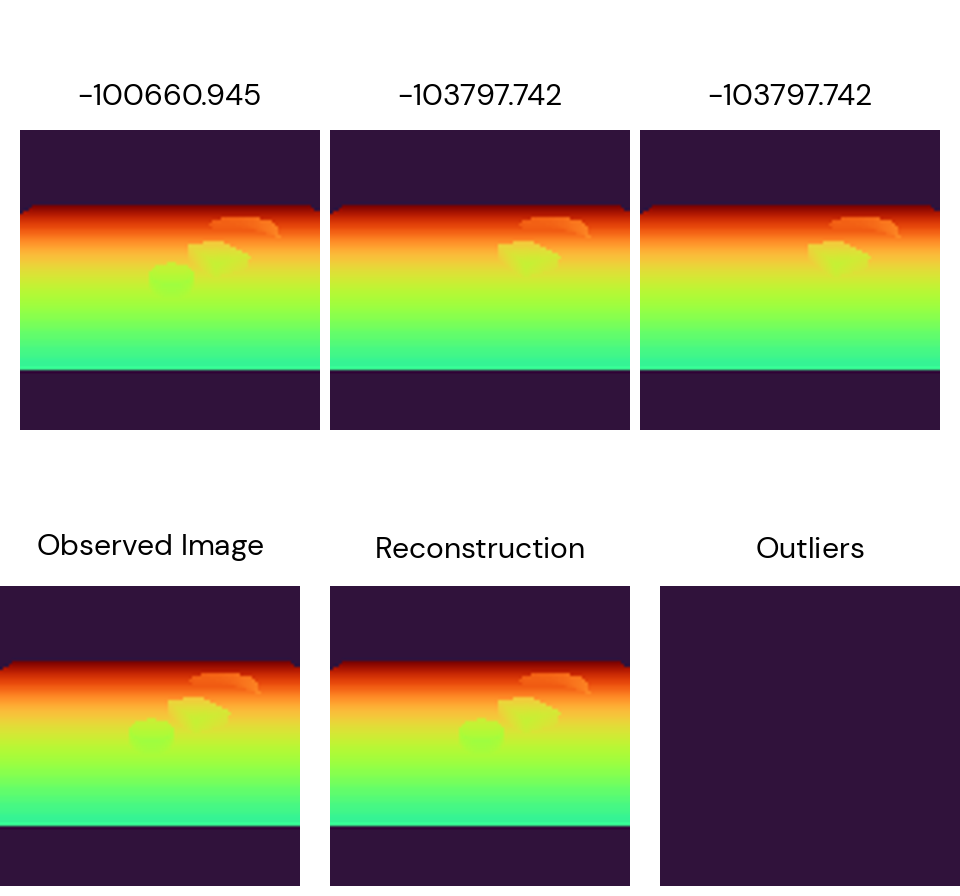

In [42]:
all_hypotheses = []
for obj_id in indices:
    print("Object Id : ", obj_id)
    potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
        contact_param_grid,
        3,
        renderer.model_box_dims[obj_id],
        contact_plane
    )
    POTENTIAL_R = jnp.hstack([R,R_SWEEP])
    
    potential_poses = jnp.concatenate(
        [
            jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
            potential_new_object_poses[None,...]
        ]
    )
    reconstruction = renderer.render_multiobject_parallel(
        potential_poses, object_ids + [obj_id]
    )
    p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(observed_img, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1], POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME)
    ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])
    print(contact_param_grid[ii])
    print(p[ii,jj,kk])
    print(best_r, best_outlier_prob)
    
    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )
    
best_hypothesis = all_hypotheses[jnp.argmax(jnp.array([i[0] for i in all_hypotheses]))]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis

R = POTENTIAL_R.at[:,:].set(best_r)
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id.item()]


outliers = (
    (j.gaussian_mixture_image_multi_r_jit(observed_img, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r) * (1.0 - best_outlier_prob)) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)

# height_factor = outlier_prob_viz.height / observed_image_viz.height

viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:0.3f}".format(i[0].item()).format(i[0].item()) for i in all_hypotheses]
)
viz2 = j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)
j.vstack_images([viz1, viz2])

In [28]:
best_r

Array([1.  , 1.  , 0.01, 0.01, 0.05], dtype=float32)